In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pydmps.dmp_discrete import DMPs_discrete
from pydmps.dmp_rhythmic import DMPs_rhythmic

In [2]:
# Loading the data

try:
    import re
    with open('data.txt', 'r') as f:
        text = f.read()
        text = text.replace('[', '').replace(']', '').replace('\n', '')
        trajectory_data = np.fromstring(text, sep=' ').reshape(-1, 7)
except:
    print("Trajectory not found")
    trajectory_data = np.zeros((400, 7))

In [3]:
# Segment the trajectory data to get reaching and stirring parts

split_idx = 140 

reach_data_full = trajectory_data[:split_idx, :]
stir_data_full = trajectory_data[split_idx:, :]

# 7 discrete DMP objects and 7 rhythmic DMP objects
dmp_reach_list = []
dmp_stir_list = []

n_dims = 7
n_bfs = 100  # Basis functions per DMP

In [4]:
# Training
for i in range(n_dims):
    # The library expects shape (n_dmps, timesteps). 
    # Since n_dmps=1 here, we need shape (1, T).
    
    # Shape: (1, 140)
    dim_reach_traj = reach_data_full[:, i].reshape(1, -1) 
    # Shape: (1, 100)
    dim_stir_traj = stir_data_full[:100, i].reshape(1, -1)   # 100 timesteps for 1 cycle

    # --- B. Train Discrete (Reach) ---
    # We instantiate a DMP system with n_dmps=1
    d_dmp = DMPs_discrete(n_dmps=1, n_bfs=n_bfs, dt=1/split_idx)
    d_dmp.imitate_path(y_des=dim_reach_traj)
    dmp_reach_list.append(d_dmp)

    # --- C. Train Rhythmic (Stir) ---
    r_dmp = DMPs_rhythmic(n_dmps=1, n_bfs=n_bfs, dt=0.01)
    r_dmp.imitate_path(y_des=dim_stir_traj)
    dmp_stir_list.append(r_dmp)

In [5]:
# Regenerate

generated_reach_paths = []
generated_stir_paths = []

stir_duration = 400-split_idx # How long to run the rhythmic part

for i in range(n_dims):
    # --- A. Rollout Discrete ---
    # Retrieve the trained model for this dimension
    d_dmp = dmp_reach_list[i]
    
    # Rollout (returns y, dy, ddy)
    y_reach, _, _ = d_dmp.rollout(timesteps=split_idx)
    
    # --- B. Link Boundaries ---
    # We need the Rhythmic DMP to start exactly where the Discrete DMP ended.
    r_dmp = dmp_stir_list[i]
    
    # Get the last position of the reaching phase
    last_reach_pos = y_reach[-1]
    
    # Set the initial state of the rhythmic DMP to match
    r_dmp.y0 = last_reach_pos
    # IMPORTANT: We must reset the state for y0 to take effect on the internal variables
    r_dmp.reset_state()
    
    # --- C. Rollout Rhythmic ---
    y_stir, _, _ = r_dmp.rollout(timesteps=stir_duration)
    
    # Store results
    generated_reach_paths.append(y_reach)
    generated_stir_paths.append(y_stir)

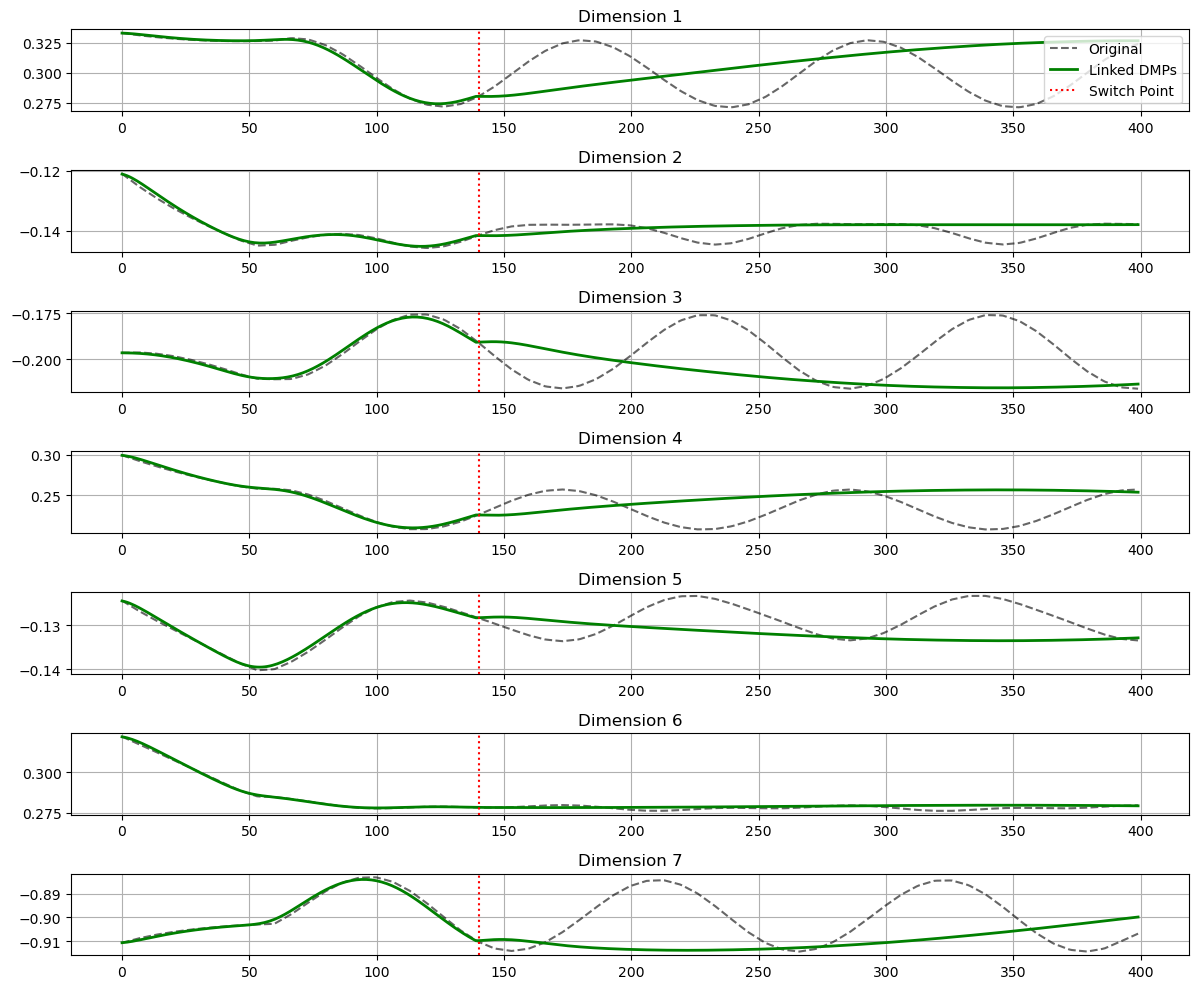

In [6]:
full_reach = np.hstack(generated_reach_paths)
full_stir = np.hstack(generated_stir_paths)

# Concatenate vertically to make one continuous trajectory
full_trajectory = np.vstack((full_reach, full_stir))

# Plotting
plt.figure(figsize=(12, 10))

# Plot only first 3 dims to keep graph clean
for dim in range(7): 
    plt.subplot(7, 1, dim+1)
    
    # 1. Plot original data
    plt.plot(trajectory_data[:, dim], 'k--', alpha=0.6, label='Original')
    
    # 2. Plot Regenerated Data
    # The X-axis for generated data might differ slightly if time durations changed,
    # but here they should align closely.
    plt.plot(full_trajectory[:, dim], 'g', linewidth=2, label='Linked DMPs')
    
    # Draw vertical line at split point
    plt.axvline(x=split_idx, color='r', linestyle=':', label='Switch Point')
    
    plt.title(f'Dimension {dim+1}')
    plt.grid(True)
    if dim == 0:
        plt.legend(loc='upper right')

plt.tight_layout()
plt.show()